# Drone Dynamics

> **Note:** These examples demonstrate the use of RxInfer for motion planning.
> The animations show the inferred trajectories from probabilistic inference, rather than simulated executions.
> For more realistic simulations, especially in the 3D drone example, the model would need to be
> extended with a reactive environment that responds to the drone's actions during plan execution.
> If you're interested in collaborating on a more realistic implementation, please open a [discussion](https://github.com/orgs/ReactiveBayes/discussions)
> and let's work on it together!

In [1]:
using RxInfer, LinearAlgebra

## Defining structures

In [2]:
"""
    Environment(; gravitational_constant::Float64 = 9.81)

This structure contains the properties of the environment.
"""
Base.@kwdef struct Environment
    gravitational_constant::Float64 = 9.81
end
get_gravity(env::Environment) = env.gravitational_constant

get_gravity (generic function with 1 method)

In [3]:
"""
    Drone(mass, inertia, radius, force_limit)

This structure contains the properties of the drone.
"""
Base.@kwdef struct Drone
    mass::Float64
    inertia::Float64
    radius::Float64
    force_limit::Float64
end
get_mass(drone::Drone) = drone.mass
get_properties(drone::Drone) = (drone.mass, drone.inertia, drone.radius, drone.force_limit)

get_properties (generic function with 1 method)

In [4]:
"""
    State(x, y, vx, vy, 𝜃, 𝜔)

This structure contains the state of the drone. It contains the position, velocity, and orientation of the drone.
"""
struct State
    x::Float64
    y::Float64
    vx::Float64
    vy::Float64
    𝜃::Float64
    𝜔::Float64
end
get_state(state::State) = (state.x, state.y, state.vx, state.vy, state.𝜃, state.𝜔)

get_state (generic function with 1 method)

## Model specification

In [5]:
"""
    state_transition(state, actions, drone, environment, dt)

This function computes the next state of the drone given the current state, the actions, the drone properties and the environment properties.
"""
function state_transition(state, actions, drone::Drone, environment::Environment, dt)

    # extract drone properties
    m, I, r, limit  = get_properties(drone)

    # extract environment properties
    g = get_gravity(environment)

    # extract feasible actions
    Fl, Fr   = clamp.(actions, 0, limit)
        
    # extract state properties
    x, y, vx, vy, θ, ω = state

    # compute forces and torques
    Fg = m * g
    Fy = (Fl + Fr) * cos(θ) - Fg
    Fx = (Fl + Fr) * sin(θ)
    𝜏  = (Fl - Fr) * r

    # compute movements
    ax = Fx / m
    ay = Fy / m
    vx_new = vx + ax * dt
#     vy_new = vx + ay * dt # old version
    vy_new = vy + ay * dt   # new version
    x_new  = x + vx * dt + ax * dt^2 / 2
    y_new  = y + vy * dt + ay * dt^2 / 2
        
    # compute rotations
    α = 𝜏 / I
    ω_new = ω + α * dt
    θ_new = θ + ω * dt + α * dt^2 / 2
	
    return [x_new, y_new, vx_new, vy_new, θ_new, ω_new]

end

state_transition

In [6]:
@model function drone_model(drone, environment, initial_state, goal, horizon, dt)	

	# extract environment properties
	g = get_gravity(environment)

	# extract drone properties
	m = get_mass(drone)

	# initial state prior
	s[1] ~ MvNormal(mean = initial_state, covariance = 1e-5 * I)

	for i in 1:horizon

		# prior on actions (mean compensates for gravity)
		u[i] ~ MvNormal(μ = [m * g / 2, m * g / 2], Σ = diageye(2))

		# state transition
		s[i + 1] ~ MvNormal(
            μ = state_transition(s[i], u[i], drone, environment, dt), 
			Σ = 1e-10 * I
		)
	end
	
	s[end] ~ MvNormal(mean = goal, covariance = 1e-5 * diageye(6))

end

## Probabilistic inference

In [7]:
@meta function drone_meta()

	# approximate the state transition function using the Unscented transform
	state_transition() -> Unscented()

end

drone_meta (generic function with 1 method)

In [8]:
function move_to_target(drone::Drone, env::Environment, start::State, target, horizon, dt)

    results = infer(
        model = drone_model(
            drone = drone, 
            environment = env,
            horizon = horizon,
            dt = dt
        ),
        data  = (
            initial_state = collect(get_state(start)), 
            goal = [target[1], target[2], 0, 0, 0, 0],
        ),
        meta  = drone_meta(),
        returnvars = (s = KeepLast(), u = KeepLast())
    )

    return results

end

move_to_target (generic function with 1 method)

In [9]:
drone = Drone(
    mass = 1,
    inertia = 1,
    radius = 0.2,
    force_limit = 15.0
)

env = Environment()

start = State(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

target = [-0.8, 0.6]

results = move_to_target(drone, env, start, target, 40, 0.05)

Inference results:
  Posteriors       | available for (s, u)


## Plotting

In [10]:
using Plots

In [11]:
function plot_drone!(p, drone::Drone, state::State; color = :black)
    x, y, x_a, y_a, θ, ω = get_state(state)
    _, _, radius, _ = get_properties(drone)
    dx = radius * cos(θ)
    dy = radius * sin(θ)

    drone_position = [ x ], [ y ]
    drone_engines  = [ x - dx, x + dx ], [ y + dy, y - dy ]
    drone_coordinates = [ x - dx, x, x + dx ], [ y + dy, y, y - dy ]

    rotation_matrix = [ cos(-θ) -sin(-θ); sin(-θ) cos(-θ) ]
    engine_shape = [ -1 0 1; 1 -1 1 ]
    drone_shape  = [ -2 -2 2 2 ; -1 1 1 -1 ]
    
    engine_shape = rotation_matrix * engine_shape
    drone_shape  = rotation_matrix * drone_shape
    engine_marker = Shape(engine_shape[1, :], engine_shape[2, :])
    drone_marker  = Shape(drone_shape[1, :], drone_shape[2, :])
    
    scatter!(p, drone_position[1], drone_position[2]; color = color, label = false, marker = drone_marker)
    scatter!(p, drone_engines[1], drone_engines[2]; color = color, label = false, marker = engine_marker, ms = 10)
    plot!(p, drone_coordinates; color = color, label = false)

    return p
end

plot_drone! (generic function with 1 method)

In [12]:
function animate_drone(drone::Drone, target, results::InferenceResult)

    states = hcat(map(p -> mean(p), results.posteriors[:s])...)
    

    animation = @animate for k in 1:size(states,2)

        # plot target
        p = scatter([target[1]], [target[2]], label = "target"; color = :red)

        # plot drone
        plot_drone!(p, drone, State(states[:, k]...))

        xlims!(-1.5, 1.5)
        ylims!(-1.5, 1.5)
    
    end

    gif(animation, "drone.gif", show_msg = false)

    nothing
end

animate_drone (generic function with 1 method)

In [13]:
animate_drone(drone, target, results)

![](drone.gif)

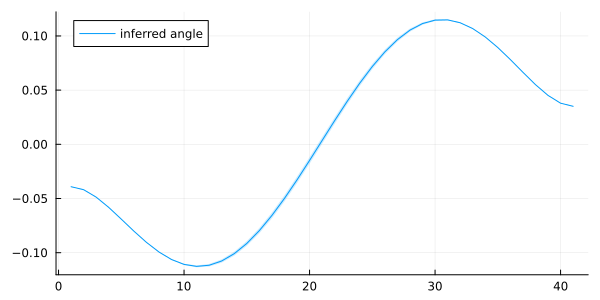

In [14]:
let 
    inferred_angle_mean = map(p -> mean(p)[5], results.posteriors[:s])
    inferred_angle_std  = map(p -> std(p)[5],  results.posteriors[:s])
    plot(inferred_angle_mean; ribbon = inferred_angle_std, fillalpha = 0.2, label = "inferred angle", size=(600,300))
end

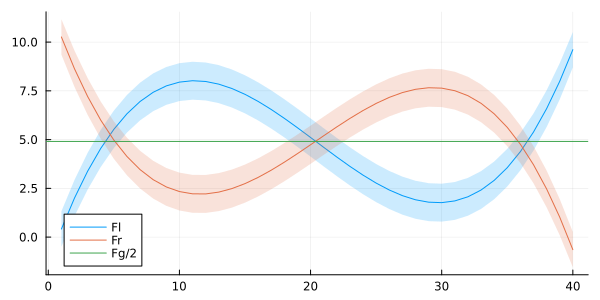

In [15]:
let 
    inferred_forces_mean = hcat(map(p -> mean(p), results.posteriors[:u])...)'
    inferred_forces_std  = hcat(map(p -> sqrt.(var(p)),  results.posteriors[:u])...)'
    plot(inferred_forces_mean[:,1]; ribbon = inferred_forces_std[:,1], fillalpha = 0.2, label = "Fl", size=(600,300))
    plot!(inferred_forces_mean[:,2]; ribbon = inferred_forces_std[:,2], fillalpha = 0.2, label = "Fr", size=(600,300))
    
    hline!([get_mass(drone) * get_gravity(env) / 2], label = "Fg/2")
end

## 3D Drone Extension

This section extends our 2D drone model into three-dimensional space, allowing for full spatial navigation. The model includes:

- 6 degrees of freedom (position and orientation)
- Four-motor configuration
- Basic aerodynamic forces

> **Note:** This implementation is a simplified model intended for educational purposes. While it captures the fundamental dynamics of a quadcopter, it omits advanced aerodynamic effects and motor dynamics for clarity.

In [89]:
# Extended Drone structure for 4 motors
Base.@kwdef struct Drone3D
    mass::Float64
    inertia::Matrix{Float64}  # 3x3 inertia matrix
    radius::Float64
    arm_length::Float64
    force_limit::Float64
end

Drone3D

In [90]:
function get_properties(drone::Drone3D)
    return (
        drone.mass,
        drone.inertia,
        drone.radius,
        drone.arm_length,
        drone.force_limit
    )
end

get_properties (generic function with 2 methods)

In [91]:
# Extended State for 3D
struct State3D
    x::Float64   # position
    y::Float64
    z::Float64
    vx::Float64  # velocity
    vy::Float64
    vz::Float64
    ϕ::Float64   # roll
    θ::Float64   # pitch
    ψ::Float64   # yaw
    ωx::Float64  # angular velocity
    ωy::Float64
    ωz::Float64
end

In [92]:
function get_state(state::State3D)
    return (
        state.x, state.y, state.z,
        state.vx, state.vy, state.vz,
        state.ϕ, state.θ, state.ψ,
        state.ωx, state.ωy, state.ωz
    )
end

get_state (generic function with 2 methods)

In [93]:
"""
    rotation_matrix(ψ, θ, ϕ)

Create a 3D rotation matrix from yaw (ψ), pitch (θ), and roll (ϕ) angles.
"""
function rotation_matrix(ψ, θ, ϕ)
    # Rotation matrices for each axis
    Rz = [cos(ψ) -sin(ψ) 0;
          sin(ψ)  cos(ψ) 0;
          0       0      1]
    
    Ry = [cos(θ)  0  sin(θ);
          0       1  0;
         -sin(θ)  0  cos(θ)]
    
    Rx = [1  0       0;
          0  cos(ϕ) -sin(ϕ);
          0  sin(ϕ)  cos(ϕ)]
    
    # Combined rotation matrix (ZYX order)
    return Rz * Ry * Rx
end

rotation_matrix

In [94]:
"""
    state_transition_3d(state, actions, drone, environment, dt)

Compute the next state of the 3D drone given current state and four motor forces.
"""
function state_transition_3d(state, actions, drone::Drone3D, environment::Environment, dt)
    # Extract properties
    m, I, r, L, limit = get_properties(drone)
    g = get_gravity(environment)
    
    # Clamp motor forces
    F1, F2, F3, F4 = clamp.(actions, 0, limit)
    
    # Extract state
    x, y, z, vx, vy, vz, ϕ, θ, ψ, ωx, ωy, ωz = state
    
    # Current rotation matrix
    R = rotation_matrix(ψ, θ, ϕ)
    
    # Total thrust force in body frame
    F_total = sum([F1, F2, F3, F4])
    
    # Compute torques
    τx = L * (F2 - F4)  # roll torque
    τy = L * (F1 - F3)   # pitch torque
    τz = (F1 + F3 - F2 - F4) * r  # yaw torque
    
    # Forces in world frame
    F_world = R * [0, 0, F_total]
    
    # Accelerations
    ax = F_world[1] / m
    ay = F_world[2] / m
    az = F_world[3] / m - g
    
    # Angular accelerations
    α = I \ ([τx, τy, τz] - cross([ωx, ωy, ωz], I * [ωx, ωy, ωz]))
    
    # Update velocities
    vx_new = vx + ax * dt
    vy_new = vy + ay * dt
    vz_new = vz + az * dt
    
    # Update positions
    x_new = x + vx * dt + ax * dt^2 / 2
    y_new = y + vy * dt + ay * dt^2 / 2
    z_new = z + vz * dt + az * dt^2 / 2
    
    # Update angular velocities
    ωx_new = ωx + α[1] * dt
    ωy_new = ωy + α[2] * dt
    ωz_new = ωz + α[3] * dt
    
    # Update angles
    ϕ_new = ϕ + ωx * dt + α[1] * dt^2 / 2
    θ_new = θ + ωy * dt + α[2] * dt^2 / 2
    ψ_new = ψ + ωz * dt + α[3] * dt^2 / 2
    
    return [
        x_new, y_new, z_new,
        vx_new, vy_new, vz_new,
        ϕ_new, θ_new, ψ_new,
        ωx_new, ωy_new, ωz_new
    ]
end

state_transition_3d

In [95]:
@model function drone_model_3d(drone, environment, initial_state, goal, horizon, dt)
    # Extract properties
    g = get_gravity(environment)
    m = drone.mass
    
    # Initial state prior
    s[1] ~ MvNormal(mean = initial_state, covariance = 1e-5 * I)
    
    for i in 1:horizon
        # Prior on motor actions (mean compensates for gravity)
        hover_force = m * g / 4
        u[i] ~ MvNormal(μ = [hover_force, hover_force, hover_force, hover_force], Σ = diageye(4))
        
        # State transition
        s[i + 1] ~ MvNormal(
            μ = state_transition_3d(s[i], u[i], drone, environment, dt),
            Σ = 1e-10 * I
        )
    end
    
    s[end] ~ MvNormal(mean = goal, covariance = 1e-5 * diageye(12))
end

In [96]:
@meta function drone_meta_3d()
    state_transition_3d() -> Unscented()
end

drone_meta_3d (generic function with 1 method)

In [97]:
function move_to_target_3d(drone::Drone3D, env::Environment, start::State3D, target, horizon, dt)
    results = infer(
        model = drone_model_3d(
            drone = drone,
            environment = env,
            horizon = horizon,
            dt = dt
        ),
        data = (
            initial_state = collect(get_state(start)),
            goal = [target[1], target[2], target[3], 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ),
        meta = drone_meta_3d(),
        returnvars = (s = KeepLast(), u = KeepLast())
    )
    
    return results
end

move_to_target_3d (generic function with 1 method)

In [98]:
function move_through_waypoints(drone::Drone3D, env::Environment, start::State3D, waypoints, steps_per_segment=40, dt=0.05)
    current_state = start
    all_results = []
    all_states = []
    
    # Move through each waypoint
    for (i, target) in enumerate(waypoints)
        println("Moving to waypoint $i: $target")
        
        # Get results for this segment
        results = move_to_target_3d(drone, env, current_state, target, steps_per_segment, dt)
        push!(all_results, results)
        
        # Extract final state for next segment
        final_states = hcat(map(p -> mean(p), results.posteriors[:s])...)
        final_state = State3D(final_states[:, end]...)
        push!(all_states, final_states)
        
        # Update current state
        current_state = final_state
    end
    
    # Combine all states for animation
    combined_states = hcat(all_states...)
    
    return combined_states, waypoints
end

move_through_waypoints (generic function with 3 methods)

In [99]:
# Visualization function for 3D drone
function plot_drone_3d!(p, drone::Drone3D, state::State3D; color=:black)
    x, y, z, _, _, _, ϕ, θ, ψ, _, _, _ = get_state(state)
    _, _, radius, arm_length, _ = get_properties(drone)
    
    # Create rotation matrix
    R = rotation_matrix(ψ, θ, ϕ)
    
    # Define arm endpoints in body frame (relative to center)
    arm_endpoints = [
        [arm_length, 0, 0],   # Right arm (X configuration)
        [0, arm_length, 0],   # Front arm
        [-arm_length, 0, 0],  # Left arm
        [0, -arm_length, 0]   # Back arm
    ]
    
    # Transform arm endpoints to world frame
    world_endpoints = []
    for endpoint in arm_endpoints
        # Convert endpoint to column vector for matrix multiplication
        endpoint_vec = reshape(endpoint, :, 1)
        # Apply rotation and translation
        world_point = R * endpoint_vec + [x, y, z]
        push!(world_endpoints, vec(world_point))
    end
    
    # Plot center
    scatter!(p, [x], [y], [z], color=color, label=false, markersize=5)
    
    # Plot arms and motors
    for endpoint in world_endpoints
        # Draw arm
        plot!(p, [x, endpoint[1]], [y, endpoint[2]], [z, endpoint[3]], 
              color=color, label=false, linewidth=2)
        # Draw motor
        scatter!(p, [endpoint[1]], [endpoint[2]], [endpoint[3]], 
                color=color, label=false, markersize=3)
    end
end

plot_drone_3d! (generic function with 1 method)

In [100]:
function animate_drone_3d_multi(drone::Drone3D, states, targets; fps=30)
    # Note: The rain animation is purely for visualization aesthetics
    # and does not affect the drone's dynamics or trajectory planning
    
    # Create initial rain streaks
    function generate_raindrops(n=50)
        x = 4 * rand(n) .- 2  # range [-2, 2]
        y = 4 * rand(n) .- 2
        z1 = 2 .+ 4 * rand(n)  # start higher up to have some offscreen
        z2 = z1 .- 0.3  # fixed length rain streaks
        return (x, y, z1, z2)
    end
    
    # Initialize raindrops
    raindrops = generate_raindrops()
    
    # Determine dynamic plot bounds based on states and targets
    x_vals = [states[1,:]; [t[1] for t in targets]]
    y_vals = [states[2,:]; [t[2] for t in targets]]
    z_vals = [states[3,:]; [t[3] for t in targets]]
    
    x_min, x_max = minimum(x_vals) - 0.5, maximum(x_vals) + 0.5
    y_min, y_max = minimum(y_vals) - 0.5, maximum(y_vals) + 0.5
    z_min, z_max = minimum(z_vals) - 0.5, maximum(z_vals) + 0.5
    
    # Ensure the plot window is at least 4x4x4 for good visualization
    x_range = max(x_max - x_min, 4.0)
    y_range = max(y_max - y_min, 4.0)
    z_range = max(z_max - z_min, 4.0)
    
    # Center the plot window
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    z_center = (z_min + z_max) / 2
    
    x_min, x_max = x_center - x_range/2, x_center + x_range/2
    y_min, y_max = y_center - y_range/2, y_center + y_range/2
    z_min, z_max = z_center - z_range/2, z_center + z_range/2
    
    animation = @animate for k in 1:size(states,2)
        # Update raindrop positions
        fall_speed = 0.1
        z1 = raindrops[3] .- fall_speed
        z2 = raindrops[4] .- fall_speed
        
        # Regenerate raindrops that have fallen below view
        below_view = findall(z2 .<= z_min)
        if !isempty(below_view)
            new_drops = generate_raindrops(length(below_view))
            raindrops[1][below_view] = new_drops[1]
            raindrops[2][below_view] = new_drops[2]
            z1[below_view] = new_drops[3]
            z2[below_view] = new_drops[4]
        end
        
        # Update raindrops state
        raindrops = (raindrops[1], raindrops[2], z1, z2)
        
        p = plot3d(
            xlims=(x_min, x_max), ylims=(y_min, y_max), zlims=(z_min, z_max),
            xlabel="X", ylabel="Y", zlabel="Z",
            camera=(45, 30),
            title="Multi-Waypoint Drone Flight",
            background=:white
        )
        
        # Draw rain streaks
        for i in 1:length(raindrops[1])
            if raindrops[4][i] > z_min  # only draw if in view
                plot!(p, [raindrops[1][i], raindrops[1][i]], 
                        [raindrops[2][i], raindrops[2][i]], 
                        [raindrops[3][i], raindrops[4][i]],
                     color=:grey, 
                     linestyle=:dash,
                     alpha=0.6,
                     legend=false,
                     linewidth=1)
            end
        end
        
        # Plot all targets
        for (i, target) in enumerate(targets)
            scatter!(p, [target[1]], [target[2]], [target[3]], 
                    label=i == 1 ? "waypoints" : false, 
                    color=:red,
                    markersize=i == 1 ? 5 : 3)
            
            # Connect waypoints with lines
            if i > 1
                prev_target = targets[i-1]
                plot!(p, [prev_target[1], target[1]], 
                         [prev_target[2], target[2]], 
                         [prev_target[3], target[3]],
                     color=:red, linestyle=:dash, label=false, linewidth=1)
            end
        end
        
        # Plot drone
        if size(states, 1) >= 12  # Make sure we have all 12 components for State3D
            current_state = State3D(states[:, k]...)
            plot_drone_3d!(p, drone, current_state)
        else
            # If we don't have enough state components, just plot a point at the position
            scatter!(p, [states[1,k]], [states[2,k]], [states[3,k]], 
                   color=:black, markersize=4, label=false)
        end
        
        # Add trajectory trace (last 100 points)
        trace_start = max(1, k-100)
        if k > 1
            plot!(p, states[1,trace_start:k], states[2,trace_start:k], states[3,trace_start:k],
                  color=:blue, label=false, linewidth=1, linealpha=0.5)
        end
    end

    gif(animation, "drone_3d_multi.gif", fps=fps, show_msg = false)

    nothing
end

animate_drone_3d_multi (generic function with 1 method)

In [102]:
# Create drone instance
drone_3d = Drone3D(
    mass = 1.0,
    inertia = diagm([0.1, 0.1, 0.15]),  # 3×3 diagonal inertia matrix
    radius = 0.1,
    arm_length = 0.2,
    force_limit = 15.0
)

env = Environment()

# Initial state
start = State3D(
    0.0, 0.0, 0.0,  # position (x, y, z)
    0.0, 0.0, 0.0,  # velocity (vx, vy, vz)
    0.0, 0.0, 0.0,  # orientation (ϕ, θ, ψ)
    0.0, 0.0, 0.0   # angular velocity (ωx, ωy, ωz)
)

# Define a sequence of waypoints for a square pattern
waypoints = [
    [1.0, 1.0, 1.0],    # Front-right corner
    [-1.0, 1.0, 1.0],   # Front-left corner
    [-1.0, -1.0, 1.0],  # Back-left corner
    [1.0, -1.0, 1.0],   # Back-right corner
    [0.0, 0.0, 0.0]     # Land at center
]

# Run simulation through all waypoints
combined_states, targets = move_through_waypoints(drone_3d, env, start, waypoints);

Moving to waypoint 1: [1.0, 1.0, 1.0]
Moving to waypoint 2: [-1.0, 1.0, 1.0]
Moving to waypoint 3: [-1.0, -1.0, 1.0]
Moving to waypoint 4: [1.0, -1.0, 1.0]
Moving to waypoint 5: [0.0, 0.0, 0.0]


In [103]:
animate_drone_3d_multi(drone_3d, combined_states, targets)

![](drone_3d_multi.gif)